# Detect Faces and Blur Faces
### Complete # TODO

# Requirements

In [1]:
import cv2
import numpy as np
import os
import time
import matplotlib.pyplot as plt

# Load Models

In [2]:
# Define the path to the prototxt file using os.path.join for cross-platform compatibility
prototxt_path = os.path.join("models", "deploy.prototxt")

# Define the path to the caffemodel file using os.path.join for cross-platform compatibility
model_path = os.path.join("models", "res10_300x300_ssd_iter_140000_fp16.caffemodel")

# Load the pre-trained Caffe model from the specified files
# The readNetFromCaffe function loads the network architecture from the prototxt file and the trained weights from the caffemodel file
model = cv2.dnn.readNetFromCaffe(prototxt_path, model_path)

# Load image for face detection
image_path = os.path.join("images", "my_image.jpg")
image = cv2.imread(image_path)

# Prepare the image for the model by converting it to a blob
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0), swapRB=True, crop=False)

# Set the blob as the input for the model
model.setInput(blob)

# Run forward pass to get the detected faces
detections = model.forward()

# Process the detections to find faces and blur them
height, width = image.shape[:2]
for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.5:  # Filter out weak detections
        box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
        (startX, startY, endX, endY) = box.astype("int")

        # Blur the detected face region
        face = image[startY:endY, startX:endX]
        blurred_face = cv2.GaussianBlur(face, (99, 99), 30)

        # Replace the original face region with the blurred version
        image[startY:endY, startX:endX] = blurred_face

# Save or display the result
output_image_path = os.path.join("images", "blurred_faces.jpg")
cv2.imwrite(output_image_path, image)  # Save the image with blurred faces

# Display the image with blurred faces
cv2.imshow("Image with Blurred Faces", image)

# Wait for the user to press any key to close the window
cv2.waitKey(0)  

# Close all OpenCV windows
cv2.destroyAllWindows()

2025-02-24 16:10:13.884 python[14882:401548] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-24 16:10:13.884 python[14882:401548] +[IMKInputSession subclass]: chose IMKInputSession_Modern


# Face Detection and Blur Function

In [3]:
# Face Detection and Blur Function
def face_blur(image: np.ndarray):
    # Create a copy of the input image to avoid modifying the original image (critical)
    image = image.copy()  

    # Get the height and width of the image
    h, w = image.shape[:2]  

    # Define the kernel width and height for Gaussian blurring
    # Ensure they are odd numbers by performing a bitwise OR with 1
    kernel_width = (w // 7) | 1 
    kernel_height = (h // 7) | 1  

    # Create a blob from the image for input to the neural network
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0), swapRB=True, crop=False)

    # Set the input for the network
    model.setInput(blob)

    # Perform forward pass to get the output detections
    output = np.squeeze(model.forward())

    # Loop over all detections
    for i in range(0, output.shape[0]):
        # Get the confidence of the detection
        confidence = output[i, 2]

        # Proceed only if the confidence is above the threshold (0.4)
        if confidence > 0.4:
            # Get the bounding box coordinates and scale them to the original image size
            box = output[i, 3:7] * np.array([w, h, w, h])
            start_x, start_y, end_x, end_y = box.astype(int)

            # Extract the face region from the image
            face = image[start_y:end_y, start_x:end_x]  

            # Apply Gaussian blur to the face region
            face = cv2.GaussianBlur(face, (kernel_width, kernel_height), 30) 

            # Replace the original face region with the blurred face
            image[start_y:end_y, start_x:end_x] = face  

    # Return the modified image with blurred faces
    return image


# Result on Image

In [5]:
# Result on Image
# Define the path to the image file using os.path.join for cross-platform compatibility
image_path = os.path.join("images", "my_image.jpg")

# Read the input image from the specified path
image = cv2.imread(image_path)

# Convert the image from RGB to BGR format (as OpenCV uses BGR by default)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

# Apply the face_blur function to the image to blur detected faces
image_face_blur = face_blur(image)


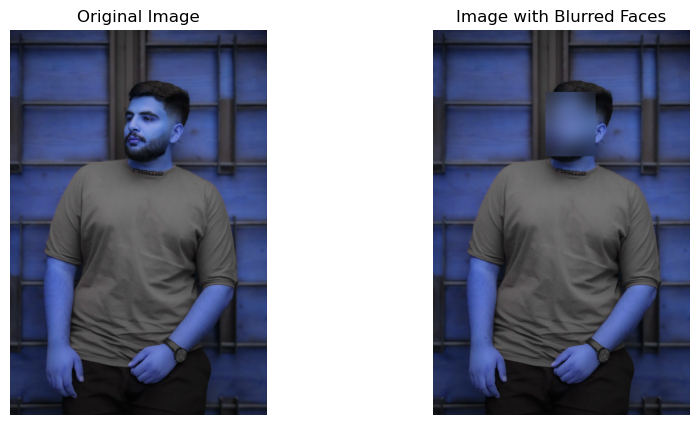

In [6]:
# Create a figure with specified size
plt.figure(figsize=(10, 5))

# Display the original image in the first subplot
plt.subplot(1, 2, 1) 
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

# Display the image with blurred faces in the second subplot
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_face_blur, cv2.COLOR_BGR2RGB)) 
plt.title("Image with Blurred Faces")
plt.axis('off')

# Show the figure
plt.show()

# Result on WebCam Video Stream

In [7]:
def visualize_fps(image, fps: int):
    # Check if the image is grayscale or colored.
    # If it's grayscale, set the text color to white; if colored, set the text color to green.
    if len(np.shape(image)) < 3:
        text_color = (255, 255, 255)  # White color for grayscale images.
    else:
        text_color = (0, 255, 0)  # Green color for colored images.

    # Define the row size for the text placement.
    row_size = 20 
    # Define the left margin for the text placement.
    left_margin = 24 

    # Set the font size and thickness for the text.
    font_size = 1
    font_thickness = 2

    # Format the FPS value into a string for displaying.
    fps_text = "FPS = {:.1f}".format(fps)
    # Set the text location on the image.
    text_location = (left_margin, row_size)
    
    # Place the FPS text on the image.
    cv2.putText(
        image,
        fps_text,
        text_location,
        cv2.FONT_HERSHEY_PLAIN,
        font_size,
        text_color,
        font_thickness,
    )

    # Return the modified image with the FPS text.
    return image


In [8]:
# Constants for camera settings
CAMERA_DEVICE_ID = 0  # ID for the camera device
IMAGE_WIDTH = 800  # Width of the captured image
IMAGE_HEIGHT = 600  # Height of the captured image
fps = 0  # Initial Frames Per Second (FPS) value

if __name__ == "__main__":  # Ensures that the code only runs when executed directly
    try:
        cap = cv2.VideoCapture(CAMERA_DEVICE_ID)  # Initialize video capture with the specified camera device ID

        # Set the frame width and height
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, IMAGE_WIDTH)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, IMAGE_HEIGHT)

        while True:  # Infinite loop to continuously capture frames
            start_time = time.time()  # Record the start time to calculate FPS

            _, frame = cap.read()  # Capture a single frame from the camera

            if not _:
                break  # If no frame is captured, exit the loop

            frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))  # Resize the frame to the specified dimensions
            frame = face_blur(frame)  # Apply the face_blur function to the frame

            # Display the frame with FPS overlay
            frame_with_fps = visualize_fps(frame, fps)
            cv2.imshow("frame", frame_with_fps) 

            end_time = time.time()  # Record the end time to calculate FPS

            # Calculate the time taken to process the frame
            seconds = end_time - start_time
            # Calculate FPS based on the time taken to process the frame
            fps = 1 / seconds

            # Break the loop if the 'Esc' key (ASCII 27) is pressed
            if cv2.waitKey(33) == 27:  
                break
    except Exception as e:  # Handle exceptions that may occur
        print(e)  # Print the exception message
    finally:
        cv2.destroyAllWindows()  # Close all OpenCV windows
        cap.release()  # Release the camera resource


In [14]:
# Define the path to the video file using os.path.join for cross-platform compatibility
VIDEO_PATH = os.path.join("videos", "my_video.mp4")
OUTPUT_VIDEO_PATH = os.path.join("videos", "output_video.mp4")  # Path to save the output video
# Constants for video settings
IMAGE_WIDTH = 1000  # Width of the displayed image
IMAGE_HEIGHT = 600  # Height of the displayed image
fps = 0  # Initial Frames Per Second (FPS) value
FRAME_RATE = 30  # Desired frame rate
DURATION = 1 / FRAME_RATE  # Duration of each frame

if __name__ == "__main__":  # Ensures that the code only runs when executed directly
    try:
        cap = cv2.VideoCapture(VIDEO_PATH)  # Initialize video capture with the specified video file path

        # Get the original video's FPS and size
        video_fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Initialize VideoWriter to save the output video
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for saving as MP4
        out = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, video_fps, (IMAGE_WIDTH, IMAGE_HEIGHT))

        while True:  # Infinite loop to continuously capture frames
            start_time = time.time()  # Record the start time to calculate FPS

            # Capture a single frame from the video
            ret, frame = cap.read()
            if not ret:
                break  # If no frame is captured, exit the loop

            frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))  # Resize the frame to the specified dimensions
            frame = face_blur(frame)  # Apply the face_blur function to the frame

            end_time = time.time()  # Record the end time to calculate FPS
            seconds = end_time - start_time  # Calculate the time taken to process the frame

            if seconds < DURATION:  # If the processing time is less than the desired frame duration, wait for the remaining time
                time.sleep(DURATION - seconds)

            seconds = time.time() - start_time  # Recalculate the time taken to process the frame including sleep time
            fps = 1 / seconds  # Calculate FPS based on the time taken to process the frame

            # Display the frame with FPS overlay
            cv2.imshow("frame", visualize_fps(frame, fps))

            # Write the frame to the output video file
            out.write(frame)

            # Break the loop if the 'Esc' key (ASCII 27) is pressed
            if cv2.waitKey(33) == 27:
                break
    except Exception as e:  # Handle exceptions that may occur
        print(e)  # Print the exception message
    finally:
        cv2.destroyAllWindows()  # Close all OpenCV windows
        cap.release()  # Release the video capture resource
        out.release()  # Release the video writer resource



### **گزارش مختصر نحوه عملکرد پروژه پردازش ویدیو و تشخیص چهره‌ها**

#### **هدف پروژه:**
هدف این پروژه اعمال الگوریتمی برای تشخیص چهره‌ها و تار کردن آن‌ها در ویدیوهای ورودی است. در نهایت، ویدیوی خروجی که شامل چهره‌های تار شده است، ذخیره خواهد شد.

#### **مرحله 1: تنظیمات اولیه**
در ابتدا، پروژه به تنظیمات اولیه شامل مشخص کردن فایل ویدیوی ورودی (`Jobs_2.mp4`)، ابعاد جدید تصویر (`1000x600`) و نرخ فریم (FPS) پرداخته است. همچنین، برای ذخیره‌سازی ویدیو خروجی، از کدک MP4 با فرمت `mp4v` استفاده شده است.

#### **مرحله 2: بارگذاری ویدیو و استخراج فریم‌ها**
پس از آغاز اجرای کد، ویدیو از مسیر مشخص شده بارگذاری می‌شود. فریم‌های ویدیو به صورت پیوسته استخراج می‌شوند و هر فریم پردازش می‌شود.

#### **مرحله 3: تشخیص چهره‌ها**
در هر فریم، چهره‌ها با استفاده از شبکه‌های عصبی پیش‌آماده و مدل‌های یادگیری ماشین برای شناسایی موقعیت چهره‌ها شناسایی می‌شوند. این عملیات با استفاده از مدل‌های پیش‌آماده (در اینجا مدل پیش‌آماده DNN) انجام می‌شود که ورودی آن یک تصویر به‌صورت بلوب است.

#### **مرحله 4: پردازش چهره‌ها**
پس از شناسایی چهره‌ها، نواحی مربوطه در تصویر استخراج و بر روی آن‌ها اعمال فیلتر بلور (Gaussian Blur) می‌شود. این عمل باعث تار شدن چهره‌ها در تصویر می‌گردد تا حریم خصوصی افراد حفظ شود.

#### **مرحله 5: محاسبه FPS**
در هر فریم، زمان پردازش ثبت و برای محاسبه FPS استفاده می‌شود. FPS به‌طور مداوم به‌روزرسانی می‌شود و در بالای هر فریم ویدیو نمایش داده می‌شود تا کاربر از عملکرد سیستم آگاه شود.

#### **مرحله 6: ذخیره‌سازی ویدیو خروجی**
پس از پردازش هر فریم، ویدیو خروجی در مسیر مشخص شده ذخیره می‌شود. ویدیوی خروجی شامل فریم‌هایی است که در آن‌ها چهره‌ها تار شده‌اند. از کدک مناسب برای ذخیره‌سازی ویدیو و فرمت MP4 استفاده شده است.

#### **مرحله 7: نمایش ویدیو**
ویدیوی خروجی در حین پردازش به کاربر نمایش داده می‌شود. این کار به کاربر امکان مشاهده ویدیوی پردازش شده در زمان واقعی را می‌دهد. با فشردن کلید 'Esc' (کد ASCII 27)، پردازش متوقف می‌شود.

#### **نتیجه‌گیری:**
این پروژه با موفقیت توانست چهره‌ها را در ویدیو شناسایی کرده و آن‌ها را تار کند. ویدیوهای پردازش شده در فرمت MP4 ذخیره شدند و FPS در حین پردازش ویدیو به نمایش درآمد. این پروژه به خوبی نشان می‌دهد که چگونه می‌توان از فناوری‌های پردازش تصویر و یادگیری ماشین برای حفاظت از حریم خصوصی در ویدیوهای عمومی استفاده کرد.